In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# WandB Setup - Import W&B and Login

In [ ]:
# Installs the W&B library
!pip install wandb --upgrade
# Imports the wandb library
import wandb
# Login to your W&B account so you can log all your metrics in one place
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=97d6fae4469cf61ace36f34526687b6b9f18f25bc47284c45b80bb7cd37bd9fb
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Setup

In [ ]:
!pip install datasets evaluate transformers
import os
import time
import datetime
from google.colab import drive
import re

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup, set_seed

import nltk
nltk.download('punkt')

!pip install sacrebleu
from datasets import load_metric

import evaluate

!pip install rouge_score

!pip install torch==2.0.0+cu118
import torch
!pip install onnx -Uq
import onnx
import torch.onnx

from nltk.tokenize import sent_tokenize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.6 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Aug 14 03:21:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create dataset



```
!unzip '/content/drive/MyDrive/AESLC-master.zip'

# Dataset Walkthrough
dataset_path = '/content/AESLC-master/enron_subject_line'
folder_paths = []
file_names = []
folders = []
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} text files in '{dirpath}'.")
    folder_paths.append(dirpath)
    file_names.append(filenames)
    folders.append(dirnames)

folder_paths = folder_paths[1:]
file_names = file_names[1:]
folders = folders[0]

data_dict, dataframe_dict = {}, {}
sub = ann0 = ann1 = ann2 = [' ']
for stage, path, names in zip(folders, folder_paths, file_names):
    body, subject, anno0, anno1, anno2 = [], [], [], [], []
    for name in names:
        with open(path+"/"+name, "r", encoding='utf-8-sig') as f:
            string = f.read()
        body_raw = re.findall(r"^.*(?=\n@subject)",string, re.S)
        body_raw[0] = body_raw[0].replace("\n",' ')
        body_raw[0] = body_raw[0].replace("\t",' ')
        body_raw[0] = body_raw[0].replace(':','-')
        body_raw[0] = re.sub(' +', ' ', body_raw[0])
        body.extend(body_raw)
        sub = re.findall(r"(?<=@subject\n).*",string) or [' ']
        sub[0] = re.sub(' +', ' ', sub[0])
        subject.extend(sub)
        ann0 = re.findall(r"(?<=@ann0\n).*",string) or [' ']
        ann0[0] = re.sub(' +', ' ', ann0[0])
        anno0.extend(ann0)
        ann1 = re.findall(r"(?<=@ann1\n).*",string) or [' ']
        ann1[0] = re.sub(' +', ' ', ann1[0])
        anno1.extend(ann1)
        ann2 = re.findall(r"(?<=@ann2\n).*",string) or [' ']
        ann2[0] = re.sub(' +', ' ', ann2[0])
        anno2.extend(ann2)
    data_dict[stage] = {'body': body,
                        'subject': subject,
                        'anno0': anno0,
                        'anno1': anno1,
                        'anno2': anno2}
    dataframe_dict[stage] = pd.DataFrame.from_dict(data_dict[stage])
data_dict.keys(), dataframe_dict.keys()

dataframe_dict['train'] = dataframe_dict['train'].drop(['anno0', 'anno1',	'anno2'], axis=1)
dataframe_dict['train'].to_csv('train_data.csv', index=None)
dataframe_dict['train'].head()

dataframe_dict['test'].to_csv('test_data.csv', index=None)
dataframe_dict['test'].head()

dataframe_dict['dev'].to_csv('dev_data.csv', index=None)
dataframe_dict['dev'].head()
```



In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/data/train_data.csv', index_col=None)
train_dataset.head()

,body,subject,anno0,anno1,anno2
0,What's up rude-dog. Haven't heard any new recr...,Hookem,,,
1,The EnronOnline Audit is scheduled to begin th...,Enron OnLine Audit Notification,,,
2,We are bringing in Associate Candidates for Su...,Associate Super Saturday,,,
3,Willy - I having an electrician come out to in...,Fixing Your Thermostat,,,
4,The information contained herein is based on s...,daily distillate and unleaded charts as attach...,,,


In [ ]:
dev_dataset = pd.read_csv('/content/drive/MyDrive/data/dev_data.csv', index_col=None)
dev_dataset.head()

,body,subject,anno0,anno1,anno2
0,"Hello Dana, Hope everything is going well for ...",Deposit,question regarding deposit on oct 30,question regarding a deposit you made,deposit question
1,Please let me know as soon as possible if you ...,Response Needed - Small Business Admin. Evalua...,know any such contracts?,information on contracts by sharon butcher,us governement review of subcontracting program
2,Attached please find the subject agreement for...,Enfolio Master Firm Purchase/Sale Agreement draft,subject agreement,subject agreement review,review subject agreement
3,1) I just talked with Scott Earnest and asked ...,Various Items,here's an update,london trip agenda,scott earnest
4,Stephanie- Here's the contact info. I don't th...,ISDA Contact,csfb contact information and request for negot...,contact info & draft request,contact information


In [ ]:
test_dataset = pd.read_csv('/content/drive/MyDrive/data/test_data.csv', index_col=None)
test_dataset.head()

,body,subject,anno0,anno1,anno2
0,A backup seat and a backup computer have been ...,Enron Center South (ECS) Move Back-up Plan,computer equipment replacement,backup workstation procedures,backup seat and computer assignment
1,eSource Presents Lexis-Nexis Training Basic Le...,Lexis-Nexis Training: Houston & Worldwide / Do...,lexis-nexis basics training in november,upcoming lexis-nexis basic training schedule a...,lexis-nexis training information
2,Due to a variety of circumstances we did not m...,"DRAFT: INFORMATION, Please Read: UBSWE Migrati...",migration of employees to ubswe,delay in employee migration,employee migration as of tonight
3,We have received the following executed ISDA M...,PLEASE READ: Pacific Gas & Electric Company,isda master agreement,executed isda master agreement contents,executed isda master agreement received
4,"Jay, the factor change has completed, go to th...",factor,instructions; changes in factor column,factor change completed,factor change completed next steps


# EDA



In [ ]:
def len_text(string):
    length = len(string.split())
    return length

In [ ]:
train_len = train_dataset.apply(np.vectorize(len_text))
train_len.head()

,body,subject,anno0,anno1,anno2
0,92,1,0,0,0
1,157,4,0,0,0
2,121,3,0,0,0
3,73,3,0,0,0
4,138,8,0,0,0


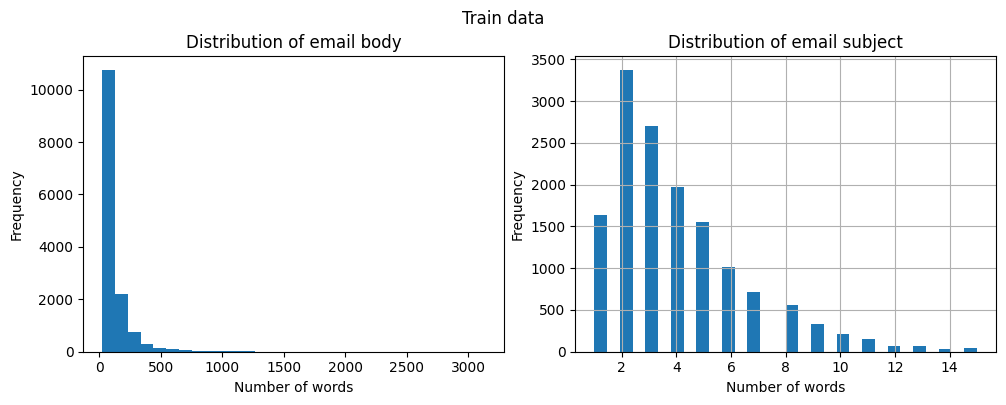

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Train data")

data = ['body', 'subject']

# We can set the number of bins with the *bins* keyword argument.
for i, axs in zip(range(len(data)),axs.flatten()):
    axs.hist(train_len[data[i]], bins=30)
    axs.set_xlabel("Number of words")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Distribution of email {data[i]}")
fig.tight_layout(pad=0.5)
plt.grid()
plt.show()

In [ ]:
train_len.describe()

,body,subject,anno0,anno1,anno2
count,14436.000000,14436.000000,14436.0,14436.0,14436.0
mean,118.231366,3.975686,0.0,0.0,0.0
std,148.968600,2.553487,0.0,0.0,0.0
min,25.000000,1.000000,0.0,0.0,0.0
25%,45.000000,2.000000,0.0,0.0,0.0
50%,74.000000,3.000000,0.0,0.0,0.0
75%,131.000000,5.000000,0.0,0.0,0.0
max,3136.000000,15.000000,0.0,0.0,0.0


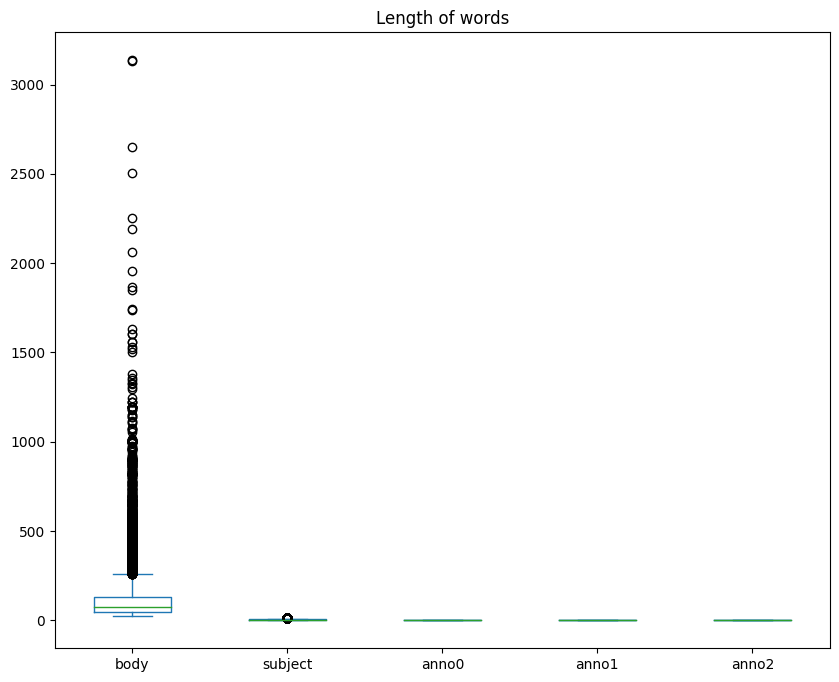

In [ ]:
train_len.plot(kind='box', title='Length of words', figsize=(10,8))
plt.show()

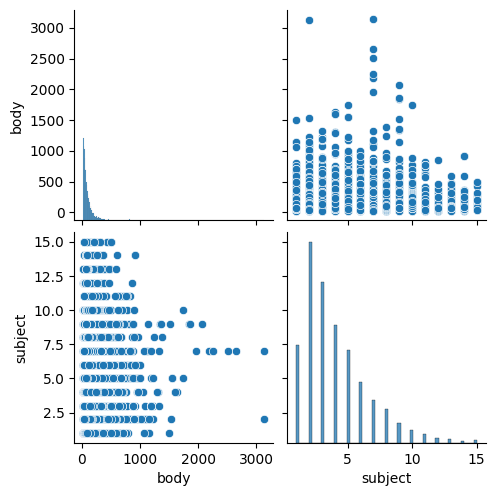

In [ ]:
# pairplot
sns.pairplot(train_len[['body','subject']])
# to show
plt.show()

In [ ]:
test_len = test_dataset.apply(np.vectorize(len_text))
test_len.head()

,body,subject,anno0,anno1,anno2
0,345,7,3,3,5
1,210,9,5,8,3
2,58,7,5,4,5
3,287,7,3,5,5
4,36,1,5,3,5


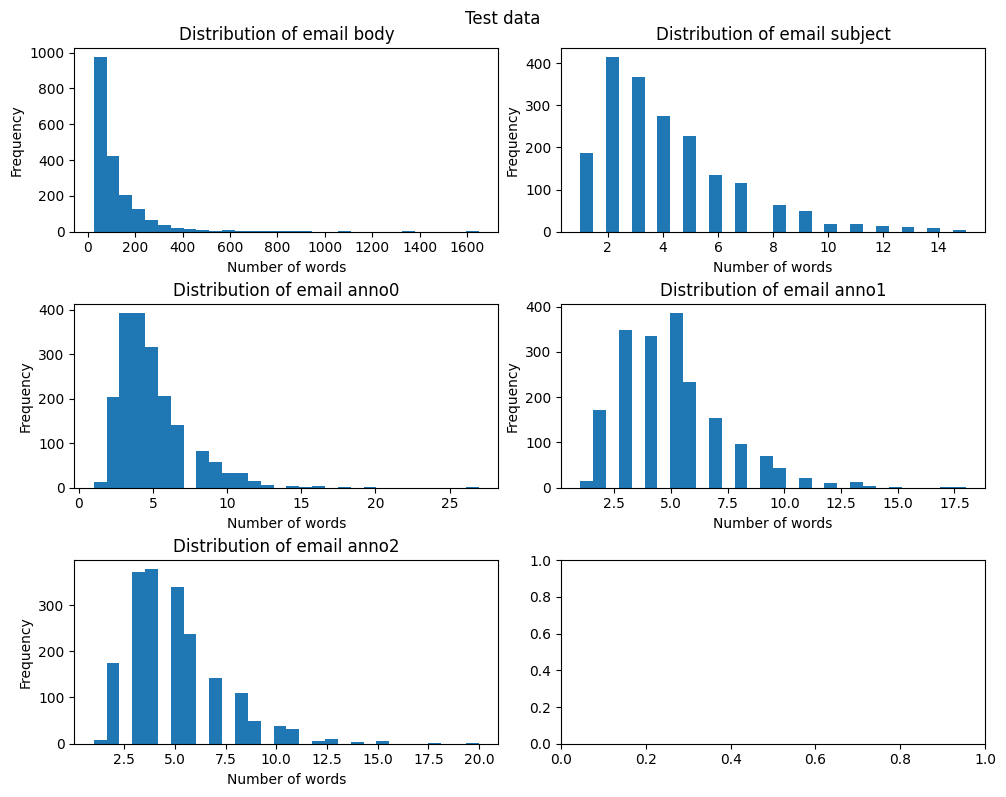

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
fig.suptitle("Test data")

data = ['body', 'subject', 'anno0', 'anno1', 'anno2']

# We can set the number of bins with the *bins* keyword argument.
for i, axs in zip(range(len(data)),axs.flatten()):
    axs.hist(test_len[data[i]], bins=30)
    axs.set_xlabel("Number of words")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Distribution of email {data[i]}")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
test_len.describe()

,body,subject,anno0,anno1,anno2
count,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000
mean,114.584995,4.078174,4.880378,5.057188,4.985310
std,116.769694,2.536386,2.442271,2.332107,2.323405
min,25.000000,1.000000,1.000000,1.000000,1.000000
25%,46.000000,2.000000,3.000000,3.000000,3.000000
50%,78.000000,3.000000,4.000000,5.000000,5.000000
75%,139.000000,5.000000,6.000000,6.000000,6.000000
max,1651.000000,15.000000,27.000000,18.000000,20.000000


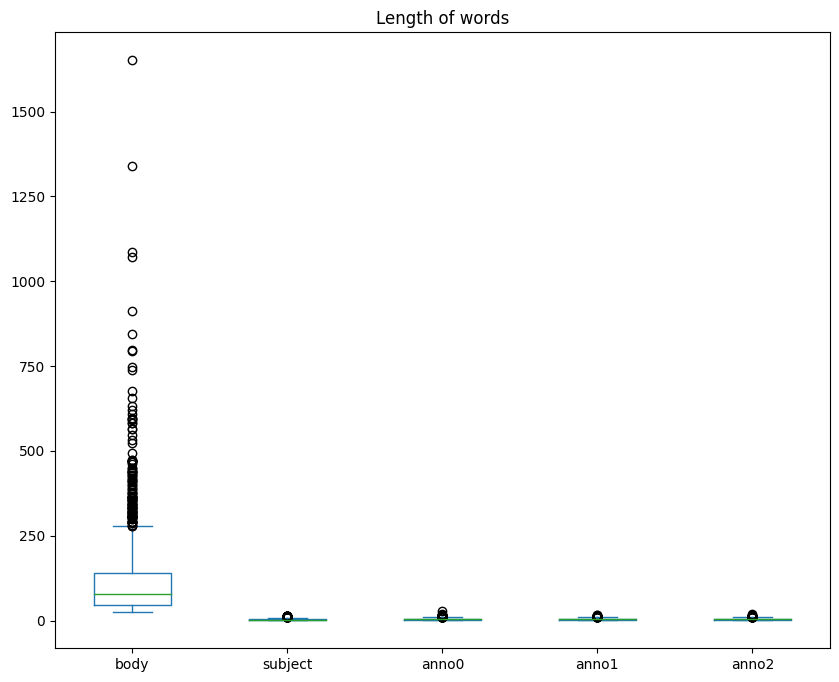

In [ ]:
test_len.plot(kind='box', title='Length of words', figsize=(10,8))
plt.show()

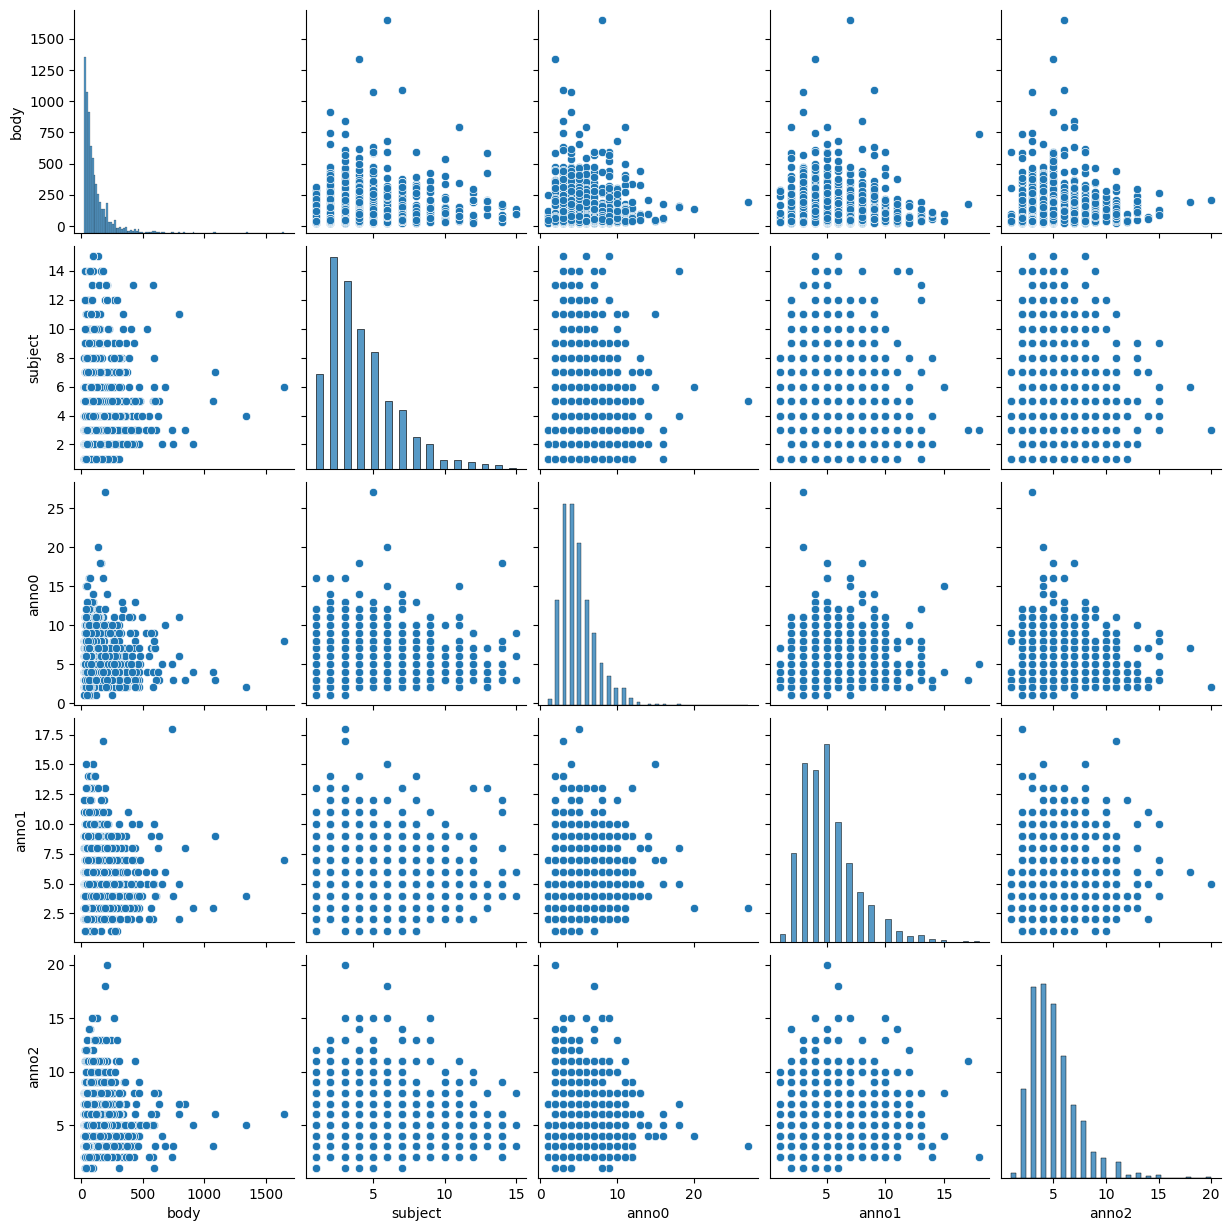

In [ ]:
# pairplot
sns.pairplot(test_len)
# to show
plt.show()

In [ ]:
dev_len = dev_dataset.apply(np.vectorize(len_text))
dev_len.head()

,body,subject,anno0,anno1,anno2
0,59,1,6,6,2
1,184,11,4,6,6
2,36,6,2,3,3
3,248,2,3,3,2
4,46,2,8,5,2


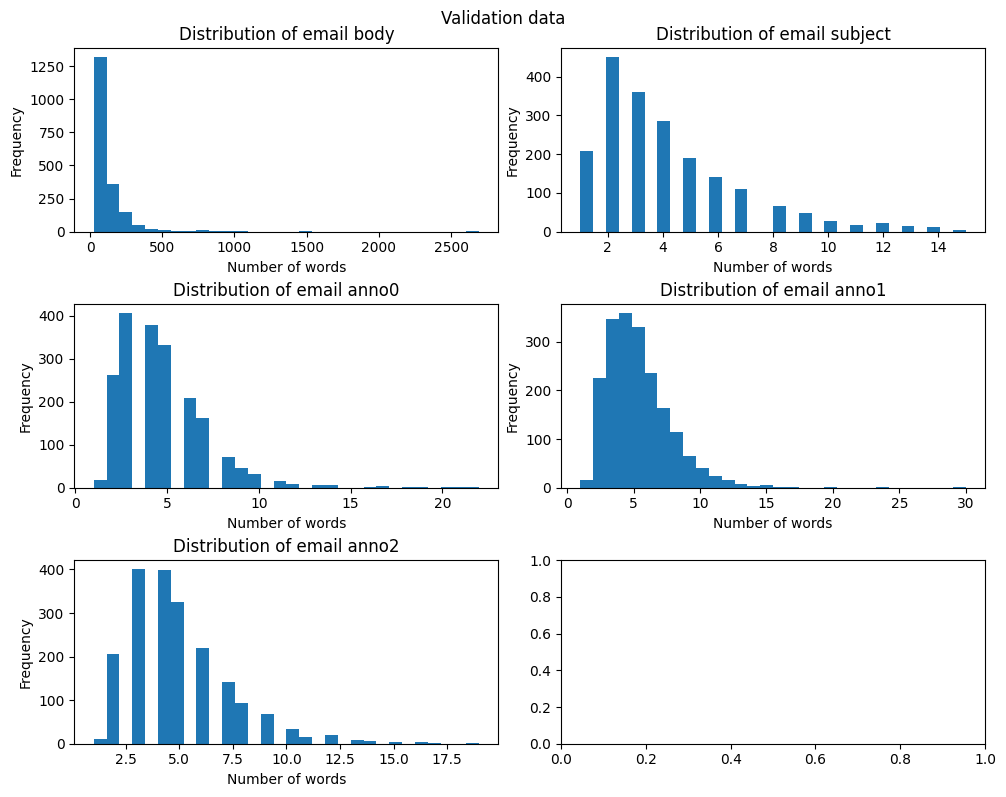

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
fig.suptitle("Validation data")

data = ['body', 'subject', 'anno0', 'anno1', 'anno2']

# We can set the number of bins with the *bins* keyword argument.
for i, axs in zip(range(len(data)),axs.flatten()):
    axs.hist(dev_len[data[i]], bins=30)
    axs.set_xlabel("Number of words")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Distribution of email {data[i]}")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
dev_len.describe()

,body,subject,anno0,anno1,anno2
count,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000
mean,124.470408,4.101020,4.720408,5.045408,4.916837
std,164.597140,2.708578,2.422329,2.564428,2.432073
min,25.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,2.000000,3.000000,3.000000,3.000000
50%,77.000000,3.000000,4.000000,5.000000,4.000000
75%,138.000000,5.000000,6.000000,6.000000,6.000000
max,2695.000000,15.000000,22.000000,30.000000,19.000000


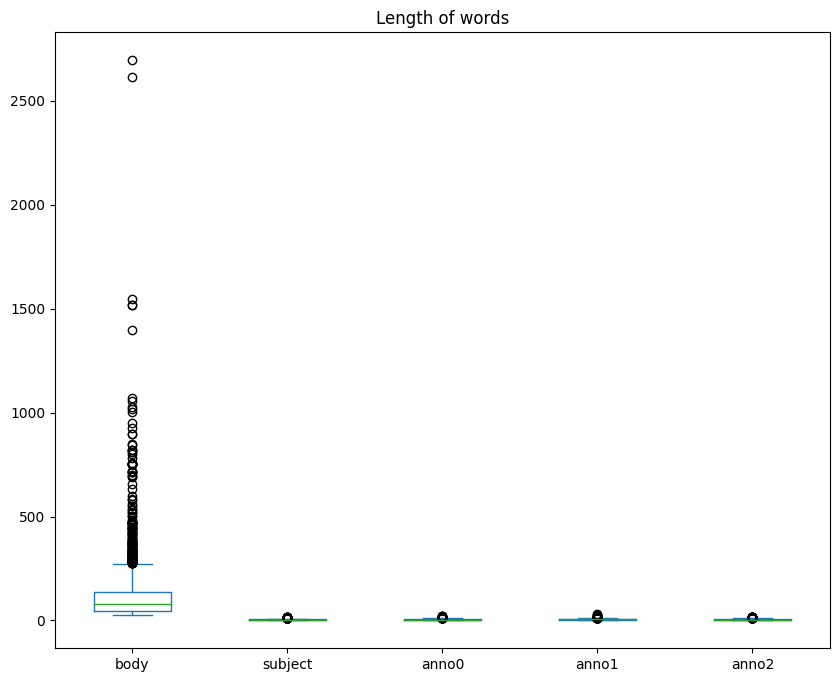

In [ ]:
dev_len.plot(kind='box', title='Length of words', figsize=(10,8))
plt.show()

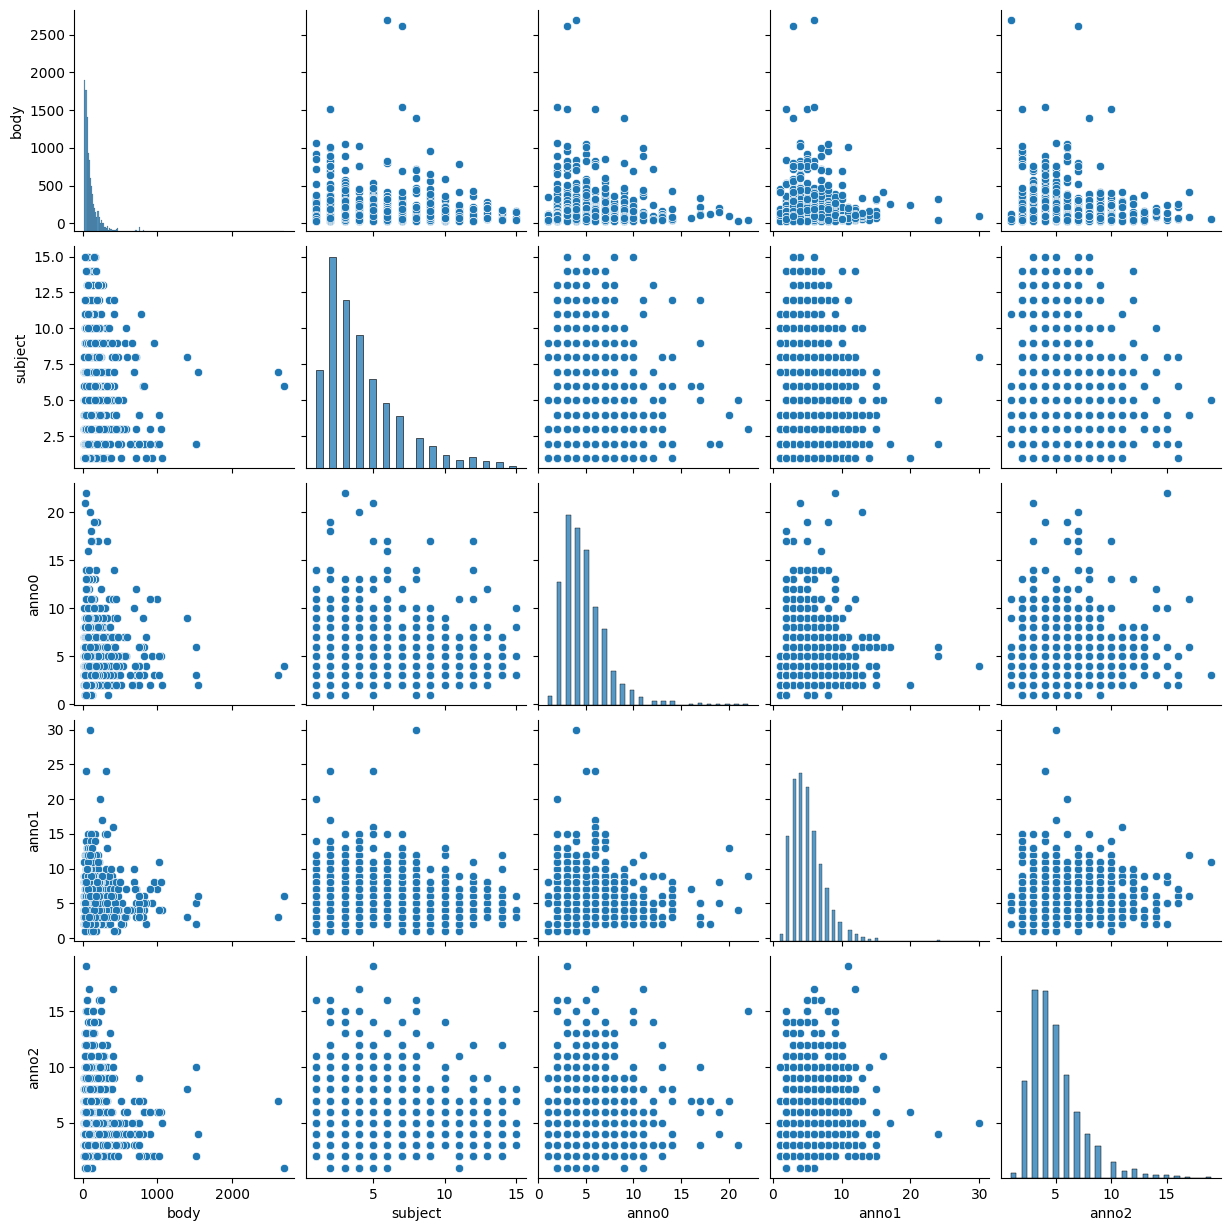

In [ ]:
# pairplot
sns.pairplot(dev_len)
# to show
plt.show()

# Initialize Hyperparameters for WandB

In [ ]:
# Capture a dictionary of hyperparameters with config
config = dict(epochs = 3,
              warmup_steps = 1e2,
              batch_size = 8, #[4, 8, 16, 32]
              epsilon = 1e-6, #[1e-5, 1e-6, 1e-7]
              gpt2_type ='olm/olm-gpt2-dec-2022', # ['distilgpt2', 'gpt2','Ar4ikov/gpt2-650k-stable-diffusion-prompt-generator','crumb/gpt2023','olm/olm-gpt2-dec-2022']
              learning_rate = 0.0001, #[0.00005, 0.0001, 0.0005, 0.001]
              max_length = 512, #[120, 160, 180, 256, 384, 448, 512]
              )

# Initializes a new W&B run. Each run is single execution of the training script.
wandb.init(project="esg_hyperopt", config=config)
config = wandb.config

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(config.gpt2_type, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

# default to left padding
tokenizer.padding_side = "left"


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50265
The end of sequence token <|endoftext|> has the id 50266
The padding token <|pad|> has the id 50267


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = config.batch_size
batch_size

8

In [ ]:
def num_words_string(body, subject, max_length):
  max_length = max_length - 20 # 5 tokens are <body> and <subject>.
  tokens = tokenizer.encode(body)[:max_length]
  decoded = tokenizer.decode(tokens)
  return decoded

In [ ]:
def tokenizer_encoding(body, subject):
  # encode_body = ['<|startoftext|>' + '<body> '+ body for body in batch['body']]
  # encode_subject = [' <subject> '+ subject + '<|endoftext|>' for subject in batch['subject']]
  encode_body = '<|startoftext|>' + '<body>'+ body
  encode_subject = '<subject>'+ subject + '<|endoftext|>'
  return encode_body, encode_subject

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self,txt_list,label_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    for txt, label in zip(txt_list,label_list):
      encodings_dict = tokenizer(tokenizer_encoding(txt, label)[0], tokenizer_encoding(txt, label)[1] ,truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
train_dataset['body'][499]

"All, Attached is a draft of a revised DASH template to better reflect some of the considerations required for asset divestitures in light of Enron's Chapter 11 status. Please let me know if you have any comments; after any comments have been incorporated, we will plan to use this as the DASH template going forward. Thanks and regards, "

In [ ]:
import logging
logging.disable(logging.WARNING)

In [ ]:
dataset_train = GPT2Dataset(train_dataset['body'],
                            train_dataset['subject'],
                            tokenizer,
                            gpt2_type=config.gpt2_type,
                            max_length=config.max_length)
dataset_train

In [ ]:
len(train_dataset)

14436

In [ ]:
tokenizer.decode(next(iter(dataset_train[499])),skip_special_tokens=True)

"<body>All, Attached is a draft of a revised DASH template to better reflect some of the considerations required for asset divestitures in light of Enron's Chapter 11 status. Please let me know if you have any comments; after any comments have been incorporated, we will plan to use this as the DASH template going forward. Thanks and regards, <subject>Draft Revised DASH Template"

In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            dataset_train,  # The training samples.
            sampler = RandomSampler(dataset_train), # Select batches randomly
            batch_size = config.batch_size # Trains with this batch size.
        )

In [ ]:
def eval_encoding(body):
  # encode_body = ['<|startoftext|>' + '<body> '+ body for body in batch['body']]
  # encode_subject = [' <subject> '+ subject + '<|endoftext|>' for subject in batch['subject']]
  encode_body = '<|startoftext|>' + '<body>'+ body
  encode_subject = '<subject>' + '<|endoftext|>'
  return encode_body, encode_subject

In [ ]:
class GPT2Dataset_EVAL(Dataset):

  def __init__(self,txt_list,label_subject, label_anno0, label_anno1, label_anno2, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.subject = []
    self.anno0 = []
    self.anno1 = []
    self.anno2 = []

    for txt, subject, anno0, anno1, anno2 in zip(txt_list,label_subject, label_anno0, label_anno1, label_anno2):

      # encodings_dict = tokenizer('<|startoftext|>' + '<body> ' + txt + '<subject> ' + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      encodings_dict = tokenizer(eval_encoding(txt)[0], eval_encoding(txt)[1], truncation=True, max_length=max_length, padding="max_length")
      # encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
      self.subject.append(subject)
      self.anno0.append(anno0)
      self.anno1.append(anno1)
      self.anno2.append(anno2)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx], self.subject[idx], self.anno0[idx], self.anno1[idx], self.anno2[idx]

In [ ]:
val_dataset = GPT2Dataset_EVAL(dev_dataset['body'],
                               dev_dataset['subject'],
                               dev_dataset['anno0'],
                               dev_dataset['anno1'],
                               dev_dataset['anno2'],
                               tokenizer, gpt2_type=config.gpt2_type,
                               max_length=512)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = config.batch_size # Evaluate with this batch size.
        )

In [ ]:
len(val_dataset)

1960

In [ ]:
tokenizer.decode(next(iter(val_dataset[0])),skip_special_tokens=True)

"<body>Hello Dana, Hope everything is going well for you. Are you learning allot of things? Well I had a question regarding a deposit you made, it's for $184,936.97 Hanson Production. Did you sent that to treasury? Did you give it to someone in particular? It has not hit any bank and it was dated Oct 30. Please help. Thanks, <subject>"

In [ ]:
test_dataset = GPT2Dataset_EVAL(test_dataset['body'],
                                test_dataset['subject'],
                                test_dataset['anno0'],
                                test_dataset['anno1'],
                                test_dataset['anno2'],
                                tokenizer, gpt2_type=config.gpt2_type,
                                max_length=512)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = config.batch_size # Evaluate with this batch size.
        )

In [ ]:
len(test_dataset)

1906

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained(config.gpt2_type, output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained(config.gpt2_type, config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = config.epochs
learning_rate = config.learning_rate
warmup_steps = config.warmup_steps
epsilon = config.epsilon

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
def return_first_match(string):
    try:
        result = re.search("(?<=<subject>).*",string).group()
        # result = re.search(".*?(?=:)",string).group()
        # result = re.search("(?=<:).*",string).group()
    except Exception or IndexError:
        result = ''
    return result

In [ ]:
# Metrics
bleu_metric = evaluate.load("sacrebleu") # evaluate.load("bleu")
# meteor_metric = evaluate.load('meteor')
rouge_metric = evaluate.load('rouge')
def compute_metric(preds, labels):
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_preds = [" ".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_preds = [return_first_match(string) for string in decoded_preds]
    bleu = bleu_metric.compute(predictions=decoded_preds, references=labels)['score']
    # meteor = meteor_metric.compute(predictions=decoded_preds, references=labels)['meteor'] *100
    rouge = rouge_metric.compute(predictions=decoded_preds, references=labels)
    rouge_R1, rouge_R2, rouge_RL, rouge_RLsum = rouge['rouge1']*100, rouge['rouge2']*100, rouge['rougeL']*100, rouge['rougeLsum']*100
    return bleu, rouge_R1, rouge_R2, rouge_RL, rouge_RLsum
    # bleu, meteor, rouge_R1, rouge_R2, rouge_RL, rouge_RLsum

In [ ]:
def subject_string(prompt):
    try:
        result = prompt.split('<subject>')[1]
    except Exception or IndexError:
        result = ''
    return result

In [ ]:
!pip install accelerate
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, training_dataloader, scheduler = accelerator.prepare(model, optimizer, train_dataloader, scheduler)

device = accelerator.device
model.to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.0 MB/s eta 0:00:00


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50268, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50268, bias=False)
)

In [ ]:
total_t0 = time.time()

wandb.watch(model, criterion=None, log="all", log_freq=10)

training_stats = []

model = model.to(device)

new_eval_rouge_R1, new_eval_rouge_R2, new_eval_rouge_RL, new_eval_rouge_RLsum = 0, 0, 0, 0
train_batch_step = 0
train_epoch_step = 0
val_batch_step = 0
val_epoch_step = 0

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    bleu_train_total = 0
    # meteor_train_total = 0
    rougeR1_train_total = 0
    rougeR2_train_total = 0
    rougeRL_train_total = 0
    rougeRLsum_train_total = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]
        batch_loss = loss.item()

        prediction = torch.argmax(outputs.logits, dim = -1)
        prediction_decoded = tokenizer.batch_decode(prediction, skip_special_tokens=True)
        subject_pred = [subject_string(pred) for pred in prediction_decoded]

        prompts = tokenizer.batch_decode(b_input_ids, skip_special_tokens=True)
        subject_prompt = [[subject_string(prompt)] for prompt in prompts]

        bleu = bleu_metric.compute(predictions=subject_pred, references=subject_prompt)['score']
        # meteor = meteor_metric.compute(predictions=subject_pred, references=subject_prompt)['meteor'] *100
        rouge = rouge_metric.compute(predictions=subject_pred, references=subject_prompt)
        rouge_R1, rouge_R2, rouge_RL, rouge_RLsum = rouge['rouge1']*100, rouge['rouge2']*100, rouge['rougeL']*100, rouge['rougeLsum']*100
        train_batch_step += 1
        wandb.log({'train_batch_no': train_batch_step,
                   'batch_train_loss': loss,
                   'batch_train_BLEU': bleu,
                   #'batch_train_METEOR': meteor,
                   'batch_train_ROUGE_R1': rouge_R1,
                   'batch_train_ROUGE_R2': rouge_R2,
                   'batch_train_ROUGE_RL': rouge_RL,
                   'batch_train_ROUGE_RLsum': rouge_RLsum})
        # print(f"Batch loss: {batch_loss}, BLEU: {bleu}, METEOR: {meteor}, ROUGE_R1: {rouge_R1}, ROUGE_R2: {rouge_R2}, ROUGE_RL: {rouge_RL} and ROUGE_RLsum: {rouge_RLsum}")

        total_train_loss += batch_loss
        bleu_train_total += bleu
        # meteor_train_total += meteor
        rougeR1_train_total += rouge_R1
        rougeR2_train_total += rouge_R2
        rougeRL_train_total += rouge_RL
        rougeRLsum_train_total += rouge_RLsum


        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}. Loss: {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            prompt = "<|startoftext|>"

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))

            model.train()

        # loss.backward()
        accelerator.backward(loss)

        optimizer.step()


        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_bleu = bleu_train_total / len(train_dataloader)
    # avg_train_meteor = meteor_train_total / len(train_dataloader)
    avg_train_rougeR1 = rougeR1_train_total / len(train_dataloader)
    avg_train_rougeR2 = rougeR2_train_total / len(train_dataloader)
    avg_train_rougeRL = rougeRL_train_total / len(train_dataloader)
    avg_train_rougeRLsum = rougeRLsum_train_total / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    train_epoch_step += 1
    wandb.log({'train_epoch_no': train_epoch_step,
               'train_epoch_loss': avg_train_loss,
               'train_epoch_bleu': avg_train_bleu,
               # 'train_epoch_meteor': avg_train_meteor,
               'train_epoch_rougeR1': avg_train_rougeR1,
               'train_epoch_rougeR2': avg_train_rougeR2,
               'train_epoch_rougeRL': avg_train_rougeRL,
               'train_epoch_rougeRLsum': avg_train_rougeRLsum})

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # example_cv = 0 #Number of examples seen
    total_eval_loss = 0
    nb_eval_steps = 0
    bleu_eval_total = 0
    # meteor_eval_total = 0
    rouge_eval_total_R1 = 0
    rouge_eval_total_R2 = 0
    rouge_eval_total_RL = 0
    rouge_eval_total_RLsum = 0

    for batch, mask, subject, anno0, anno1, anno2 in validation_dataloader:

        b_input_ids = batch.to(device)
        b_labels = batch.to(device)
        b_masks = mask.to(device)

        with torch.no_grad():

          outputs  = model(b_input_ids, token_type_ids=None, attention_mask = b_masks, labels=b_labels)
          prediction = model.generate(input_ids = b_input_ids,
                                    attention_mask = b_masks,
                                    max_new_tokens=10,
                                    pad_token_id = tokenizer.pad_token_id)

          loss = outputs[0]
          label = subject, anno0, anno1, anno2
          labels = [[i, j, k, l] for i, j, k, l in zip(subject, anno0, anno1, anno2)]
          preds, labels = prediction, labels
          bleu_score, rouge_score_R1, rouge_score_R2, rouge_score_RL, rouge_score_RLsum = compute_metric(preds, labels)
          # bleu_score, meteor_score, rouge_score_R1, rouge_score_R2, rouge_score_RL, rouge_score_RLsum = compute_metric(preds, labels)
          val_batch_step += 1
          wandb.log({'val_batch_no': val_batch_step,
                     'val_batch_loss': loss,
                     'val_batch_BLEU': bleu_score,
                     # 'val_batch_METEOR':meteor_score,
                     'val_batch_ROUGE_R1':rouge_score_R1,
                     'val_batch_ROUGE_R2':rouge_score_R2,
                     'val_batch_ROUGE_RL':rouge_score_RL,
                     'val_batch_ROUGE_RLsum':rouge_score_RLsum})

        batch_loss = loss.item()
        total_eval_loss += batch_loss
        bleu_eval_total += bleu_score
        # meteor_eval_total += meteor_score
        rouge_eval_total_R1 += rouge_score_R1
        rouge_eval_total_R2 += rouge_score_R2
        rouge_eval_total_RL += rouge_score_RL
        rouge_eval_total_RLsum += rouge_score_RLsum


    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_eval_bleu = bleu_eval_total / len(validation_dataloader)
    # avg_eval_meteor = meteor_eval_total / len(validation_dataloader)
    avg_eval_rouge_R1 = rouge_eval_total_R1 / len(validation_dataloader)
    avg_eval_rouge_R2 = rouge_eval_total_R2 / len(validation_dataloader)
    avg_eval_rouge_RL = rouge_eval_total_RL / len(validation_dataloader)
    avg_eval_rouge_RLsum = rouge_eval_total_RLsum / len(validation_dataloader)

    if (avg_eval_rouge_R1, avg_eval_rouge_R2, avg_eval_rouge_RL, avg_eval_rouge_RLsum)  >= (new_eval_rouge_R1, new_eval_rouge_R2, new_eval_rouge_RL, new_eval_rouge_RLsum):
      (new_eval_rouge_R1, new_eval_rouge_R2, new_eval_rouge_RL, new_eval_rouge_RLsum) = (avg_eval_rouge_R1, avg_eval_rouge_R2, avg_eval_rouge_RL, avg_eval_rouge_RLsum)
      print(f"Model Saved during epoch number {epoch_i+1}")
      output_dir = './model_save/'
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

    validation_time = format_time(time.time() - t0)

    val_epoch_step += 1
    wandb.log({'val_epoch_no': val_epoch_step,
               'val_epoch_loss': avg_val_loss,
               'val_epoch_BLEU': avg_eval_bleu,
               # 'val_epoch_METEOR':avg_eval_meteor,
               'val_epoch_ROUGE_R1':avg_eval_rouge_R1,
               'val_epoch_ROUGE_R2': avg_eval_rouge_R2,
               'val_epoch_ROUGE_RL': avg_eval_rouge_RL,
               'val_epoch_ROUGE_RLsum': avg_eval_rouge_RLsum})

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation BLEU: {0:.2f}".format(avg_eval_bleu))
    # print("  Validation METEOR: {0:.2f}".format(avg_eval_meteor))
    print("  Validation ROUGE_R1: {0:.2f}".format(avg_eval_rouge_R1))
    print("  Validation ROUGE_R2: {0:.2f}".format(avg_eval_rouge_R2))
    print("  Validation ROUGE_RL: {0:.2f}".format(avg_eval_rouge_RL))
    print("  Validation ROUGE_RLsum: {0:.2f}".format(avg_eval_rouge_RLsum))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'Valid. Loss': avg_val_loss,
            'Valid. BLEU': avg_eval_bleu,
            # 'Valid. METEOR': avg_eval_meteor,
            'Valid. ROUGE_R1': avg_eval_rouge_R1,
            'Valid. ROUGE_R2': avg_eval_rouge_R2,
            'Valid. ROUGE_RL': avg_eval_rouge_RL,
            'Valid. ROUGE_RLsum': avg_eval_rouge_RLsum,
            'Validation Time': validation_time
        }
    )


print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
Batch   100  of  1,805. Loss: 1.8056344985961914. Elapsed: 0:03:13.
0:  1909 in Los Angeles County, California, United States.  He was the third child of the John J. and Mildred L. Keeling, who moved to San Francisco in 1926 and was working as a car salesman.  The couple had lived in Marin County until they moved to the San Francisco Bay Area in the 1940s.  In addition to their two sons, the family had several other children including a daughter, Mary L. Leeper, who married in 1953 and moved to Oakland in the 1980s.  Their grandson, Charles Leeper, is active in the community and is a lawyer.  He is also the author of numerous articles on the San Francisco Bay Area and the California community.  He currently lives in Oakland and writes the article "The San Francisco Bay Area's Future" with Mark
Batch   200  of  1,805. Loss: 1.0569206476211548. Elapsed: 0:07:18.
0:  Ir to the left of the main screen, and, at the same time, they changed the "Jude

OutOfMemoryError: ignored

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving Fine-Tuned Model into drive

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!ls -l --block-size=K ./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

In [ ]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ '/content/drive/MyDrive'
!zip -r model_save.zip model_save/
!cp model_save.zip /content/drive/MyDrive
# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

In [ ]:
wandb.finish()

# Testing with Saved model

In [ ]:
t0 = time.time()

testing_stats = []
total_test_loss = 0
nb_test_steps = 0
bleu_test_total = 0
meteor_test_total = 0
rouge_test_total_R1 = 0
rouge_test_total_R2 = 0
rouge_test_total_RL = 0
rouge_test_total_RLsum = 0



# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained('/content/model_save')
tokenizer = GPT2Tokenizer.from_pretrained('/content/model_save')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate data for one epoch
for batch, mask, subject, anno0, anno1, anno2 in test_dataloader:
  b_input_ids = batch.to(device)
  b_labels = batch.to(device)
  b_masks = mask.to(device)
  with torch.no_grad():

    outputs  = model(b_input_ids, token_type_ids=None, attention_mask = b_masks, labels=b_labels)
    prediction = model.generate(input_ids = b_input_ids,
                                attention_mask = b_masks,
                                max_new_tokens=10,
                                pad_token_id = tokenizer.pad_token_id)

    loss = outputs[0]
    label = subject, anno0, anno1, anno2
    labels = [[i, j, k, l] for i, j, k, l in zip(subject, anno0, anno1, anno2)]
    preds, labels = prediction, labels
    bleu_score, rouge_score_R1, rouge_score_R2, rouge_score_RL, rouge_score_RLsum = compute_metric(preds, labels)
    # bleu_score, meteor_score, rouge_score_R1, rouge_score_R2, rouge_score_RL, rouge_score_RLsum = compute_metric(preds, labels)


  batch_loss = loss.item()
  total_test_loss += batch_loss
  bleu_test_total += bleu_score
  # meteor_test_total += meteor_score
  rouge_test_total_R1 += rouge_score_R1
  rouge_test_total_R2 += rouge_score_R2
  rouge_test_total_RL += rouge_score_RL
  rouge_test_total_RLsum += rouge_score_RLsum


avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_bleu = bleu_test_total / len(test_dataloader)
# avg_test_meteor = meteor_test_total / len(test_dataloader)
avg_test_rouge_R1 = rouge_test_total_R1 / len(test_dataloader)
avg_test_rouge_R2 = rouge_test_total_R2 / len(test_dataloader)
avg_test_rouge_RL = rouge_test_total_RL / len(test_dataloader)
avg_test_rouge_RLsum = rouge_test_total_RLsum / len(test_dataloader)

test_time = format_time(time.time() - t0)

print("Testing...")
print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test BLEU: {0:.2f}".format(avg_test_bleu))
# print("  Test METEOR: {0:.2f}".format(avg_test_meteor))
print("  Test ROUGE_R1: {0:.2f}".format(avg_test_rouge_R1))
print("  Test ROUGE_R2: {0:.2f}".format(avg_test_rouge_R2))
print("  Test ROUGE_RL: {0:.2f}".format(avg_test_rouge_RL))
print("  Test ROUGE_rouge_RLsum: {0:.2f}".format(avg_test_rouge_RLsum))
print("  Test Time: {:}".format(test_time))

# Record all statistics from this epoch.
testing_stats.append(
        {
            'Testing Loss': avg_test_loss,
            'Testing BLEU': avg_test_bleu,
            # 'Testing METEOR': avg_test_meteor,
            'Testing ROUGE_R1': avg_test_rouge_R1,
            'Testing ROUGE_R2': avg_test_rouge_R2,
            'Testing ROUGE_RL': avg_test_rouge_RL,
            'Testing ROUGE_RLsum': avg_test_rouge_RLsum,
            'Testing Time': test_time
        }
    )

print("")
print("Testing complete!")
print("Total testing took {:} (h:mm:ss)".format(format_time(time.time()-t0)))